# Brand Identity Tool
This notebook wires three different systems into a single identity pipeline that helps transform creative ideas into production-ready brand assets. The pipeline is therefore organized as follows:
- **System A: Identity Definer (LLM)** creates an identity manifest from a vague concept.
- **System B: Visual Generator (Diffusion + Adapters)** renders images from the generated manifest.
- **System C: Quality Critic (VLM)** measures visual drift by comparing to what extent outcomes align with the manifest.

Please be welcome to use this notebook to run tests, then save manifests, prompts, images, and scores. Enjoy!

## 1. Project Environment (One-Time Setup)
These cells create a local `.venv`, install minimal packages, and register a Jupyter kernel.


In [41]:
# create the project venv (one-time)
! python -m venv .venv

Error: [Errno 13] Permission denied: 'c:\\Users\\pavel\\OneDrive\\Desktop\\GenAI Project\\code\\.venv\\Scripts\\python.exe'


In [42]:
# # install packages for the notebook (full set)
# ! .\.venv\Scripts\python -m pip install -r requirements.txt

# install packages for the notebook (minimal set)
! .\.venv\Scripts\python -m pip install -r requirements_min.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement torch==2.6.0+cu121 (from versions: 2.0.0, 2.0.1, 2.1.0, 2.1.0+cu121, 2.1.1, 2.1.1+cu121, 2.1.2, 2.1.2+cu121, 2.2.0, 2.2.0+cu121, 2.2.1, 2.2.1+cu121, 2.2.2, 2.2.2+cu121, 2.3.0, 2.3.0+cu121, 2.3.1, 2.3.1+cu121, 2.4.0, 2.4.0+cu121, 2.4.1, 2.4.1+cu121, 2.5.0, 2.5.0+cu121, 2.5.1, 2.5.1+cu121, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.6.0+cu121

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# register the kernel
! .\.venv\Scripts\python -m ipykernel install --user --name genai-brand --display-name "GenAI Brand"

Installed kernelspec genai-brand in C:\Users\pavel\AppData\Roaming\jupyter\kernels\genai-brand


In [44]:
# verify the venv path (note: this does not change the active kernel)
! .\.venv\Scripts\python -c "import sys; print(sys.executable)"

import sys
print("Kernel Python:", sys.executable)
if ".venv" not in sys.executable:
    raise RuntimeError("""Kernel is not using .venv. To fix this:
                       1. Press Ctrl+Shift+P (Command Palette)
                       2. Type and select 'Notebook: Select Notebook Kernel'
                       3. Choose 'Select Another Kernel...' -> 'Jupyter Kernel...'
                       4. Select 'GenAI Brand' from the list
                       5. If not visible, reload VS Code window (Ctrl+Shift+P -> 'Developer: Reload Window')
                       6. Re-run this cell to verify""")
else:
    print("Kernel is correctly using .venv")

c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Scripts\python.exe
Kernel Python: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Scripts\python.exe
Kernel is correctly using .venv


In [45]:
# env setup for this notebook
import os
import sys
from pathlib import Path

try:
    from dotenv import load_dotenv
    from helpers.env_bootstrap import ensure_env_files

    cwd = Path.cwd()
    # ensure env files exist in the current working directory
    ensure_env_files(cwd)

    env_path = cwd / ".env"
    fallback_env = cwd / "code" / ".env"
    if env_path.exists():
        load_dotenv(env_path, override=False)
        print(f"Loaded env from: {env_path}")
    elif fallback_env.exists():
        load_dotenv(fallback_env, override=False)
        print(f"Loaded env from: {fallback_env}")
    else:
        print("No .env found. Create one at the project root.")
except Exception as exc:
    print(f"dotenv not loaded: {exc}")

# Ensure local modules resolve from the project root or /code
project_root = Path.cwd()
if (project_root / "identity_engine.py").exists():
    code_dir = project_root
elif (project_root / "code" / "identity_engine.py").exists():
    code_dir = project_root / "code"
else:
    code_dir = project_root

if str(code_dir) not in sys.path:
    sys.path.append(str(code_dir))

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())
print("CODE_DIR:", code_dir)

Loaded env from: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.env
Python: 3.11.9
CWD: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code
CODE_DIR: c:\Users\pavel\OneDrive\Desktop\GenAI Project\code


## 2. Imports and Utilities
Import the System A and System B engines plus common utilities used across cells.


In [46]:
# core imports
from identity_engine import IdentityDefiner
from gen_engine import VisualGenerator

import json
import numpy as np

## 3. System A: Identity Definer
System A uses LLM (llama3) to transform a high-level creative concept into a brand identity manifest. The system therefore:

- Acepts natural language input (e.g., "A futuristic samurai cat with neon whiskers")
- (Optionally) applies user constraints (required/avoided elements, style preferences, etc.)
- Generates a JSON manifest defining the brand's attributes visual style and characteristics
- Creates scene-specific prompts for System B (the Visual Generator)
- Evaluates constraint coverage to ensure the output aligns with the set requiremenst

The manifets then both conditions image generation and provides a baseline for quality evaluation in System C.

### Optional User Constraints (UI)
Use these fields to steer System A and the scene prompt. All fields are optional; leave blank to skip.

Requirements (quick guide):
- **Enable constraints**: Turn on to apply any settings.
- **Must include**: Comma-separated tokens that must appear (such as specific objects, traits, etc.)
- **Avoid**: Comma-separated tokens to discourage or block.
- **Style bias**: Preferred styles or render cues.
- **Palette bias**: Preferred colors (names or hex values).
- **Locked fields (JSON)**: Exact values to lock in the manifest (valid JSON object).
- **Extra instructions**: Natural language descriptions of constraints to steer the model.
- **Scene extra tokens**: Extra prompt tokens (for System B only).
- **Scene negative tokens**: Extra negative tokens (for System B only).
- **Override style tokens**: Replace manifest style tokens for the scene.


In [47]:
import importlib
from helpers import constraints_ui as cui

importlib.reload(cui)

cui.render_constraints_ui()

build_constraints = cui.build_constraints
build_scene_overrides = cui.build_scene_overrides
get_constraint_ui_state = cui.get_constraint_ui_state

In [48]:
# set to True after you finish adjusting the constraints UI

# proceed = False
proceed = True

In [49]:
if proceed:
    pass # continue execution
else:
    raise RuntimeError("Set 'proceed = True' after adjusting the constraints UI to continue.")

import importlib
import identity_engine
importlib.reload(identity_engine)
from identity_engine import IdentityDefiner

definer = IdentityDefiner(model_name="llama3")

user_input = "A futuristic samurai cat with neon whiskers"
ui_state = get_constraint_ui_state()
constraints = ui_state["constraints"]

manifest = definer.generate_manifest(user_input, constraints=constraints)

scene = "sitting in a ramen shop in Tokyo"
overrides = ui_state["overrides"]
prompt_pack = definer.create_scene_prompt(
    manifest,
    scene,
    extra_tokens=overrides["extra_tokens"],
    extra_negative=overrides["extra_negative"],
    override_style_tokens=overrides["override_style_tokens"],
)

manifest

# save the manifest for later use
definer.save_manifest(manifest, "outputs/manifests/samurai_cat.json")

Manifest saved to outputs/manifests/samurai_cat.json


### Inspect Prompt (for System B)
View the exact prompt and negative prompt that will be sent to the generator.


In [50]:
prompt_pack

{'prompt': '3D modeling, PBR rendering, Glowing outlines portrait of Feline humanoid warrior with cybernetic enhancements, neon whiskers, katana-shaped prosthetic limbs, augmented reality visor, color scheme: #FFC107 (Vibrant Coral), #34A85A (Electric Sage), #66D9EF (Cosmic Teal). Brand vibe: High-Tech Honor. Scene: sitting in a ramen shop in Tokyo. Additional constraints: . High resolution, consistent lighting, professional quality.',
 'negative_prompt': 'low resolution, cartoonish, inconsistent colors, human-features'}

### Constraint Coverage (Optional)
Here, we score how well the manifest aligns with the user's constraints. It only runs if constraints are enabled.

In [51]:
import importlib
from helpers import constraint_metrics as cm

importlib.reload(cm)

if ui_state["enabled"] and constraints:
    scores = cm.compute_constraint_scores(manifest, constraints)
    summary = {k: (None if v is None else round(v, 3)) for k, v in scores.items()}
    summary
    cm.plot_constraint_scores(scores)
else:
    print("Constraints disabled; no coverage metrics computed.")

Constraints disabled; no coverage metrics computed.


## 4. System B: Visual Generator
System B uses stable diffusion to render brand-consistent images from the manifest created by System A. The system therefore:

- Accepts structured prompts and negative prompts from System A's scene generator
- Supports multiple backends: local diffusers or external APIs
- Handles model loading with config precision (float16/float32), as well as device placement (CUDA/CPU)
- Generates batches of images with controllable params (resolution, steps, guidance scale, seed)
- Saves outputs to the specified directory

The generator transforms the manifest token into visual outputs for System C to evaluate.

In [52]:
# System B: Visual Generator
import importlib
import gen_engine
import torch
from gen_engine import VisualGenerator

importlib.reload(gen_engine)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM GB:", round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2))

# choose backend: 'diffusers' (local) or 'webui' (Automatic1111 API)
generator = VisualGenerator(backend="diffusers")

images = generator.generate(
    prompt=prompt_pack["prompt"],
    negative_prompt=prompt_pack.get("negative_prompt"),
    num_images=5,
    width=512,
    height=512,
    steps=25,
    guidance_scale=7.0,
    seed=42,
)

images

CUDA available: True
GPU: NVIDIA RTX A2000 8GB Laptop GPU
VRAM GB: 8.0
[diffusers] model_id=runwayml/stable-diffusion-v1-5 use_xl=False device=cuda dtype=torch.float16
[torch] cuda_available=True
[torch] gpu=NVIDIA RTX A2000 8GB Laptop GPU vram_gb=8.00


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\pavel\OneDrive\Desktop\GenAI Project\code\.venv\Lib\site-packages\diffusers\pipelines\pipeline_utils.py:2186: FutureWarning: `enable_vae_slicing` is deprecated and will be removed in version 0.40.0. Calling `enable_vae_slicing()` on a `StableDiffusionPipeline` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_slicing()`.
  deprecate(
Token indices sequence length is longer than the specified maximum sequence length for this model (103 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['tech honor . scene : sitting in a ramen shop in tokyo . additional constraints : . high resolution , consistent lighting , professional quality .']


  0%|          | 0/25 [00:00<?, ?it/s]

['outputs/images\\image_1.png',
 'outputs/images\\image_2.png',
 'outputs/images\\image_3.png',
 'outputs/images\\image_4.png',
 'outputs/images\\image_5.png']

## 5. System C: Quality Critic
System C uses CLIP (Vision-Language Model) to evaluate how well the generated images align with the manifest. The system therefore:

- Loads the generated images from System B
- Compares images against the manifest's descriptions using CLIP embeddings
- Measures semantic alignment (aka core subject, features, style, vibe)
- (Optionally) scores against the full prompt
- Returns alignment scores that quantify the drift from the intended identity

The critic provides objective feedback on whether System B successfully translated the manifest into consistent visual outputs.

In [53]:
# System C: Quality Critic (CLIP)
import importlib
import critic_engine
from critic_engine import QualityCritic

importlib.reload(critic_engine)

critic = QualityCritic()

image_paths = images if "images" in globals() else []
if not image_paths:
    raise ValueError("No images found. Run System B first.")

prompt_override = prompt_pack["prompt"] if "prompt_pack" in globals() else None
results = critic.score_images(image_paths, manifest, prompt_override=prompt_override)
results

[{'image_path': 'outputs/images\\image_1.png',
  'prompt': '3D modeling, PBR rendering, Glowing outlines portrait of Feline humanoid warrior with cybernetic enhancements, neon whiskers, katana-shaped prosthetic limbs, augmented reality visor, color scheme: #FFC107 (Vibrant Coral), #34A85A (Electric Sage), #66D9EF (Cosmic Teal). Brand vibe: High-Tech Honor. Scene: sitting in a ramen shop in Tokyo. Additional constraints: . High resolution, consistent lighting, professional quality.',
  'scores': {'prompt_similarity': 0.6522216796875,
   'feature_similarity': 0.653564453125,
   'style_similarity': 0.6201375325520834,
   'palette_similarity': 0.5843302408854166,
   'negative_similarity': 0.61212158203125,
   'final_score': 0.6310658772786457},
  'details': {'features': {'mean': 0.653564453125,
    'items': ['neon whiskers',
     'katana-shaped prosthetic limbs',
     'augmented reality visor'],
    'scores': [0.6614990234375, 0.6435546875, 0.6556396484375]},
   'styles': {'mean': 0.620137

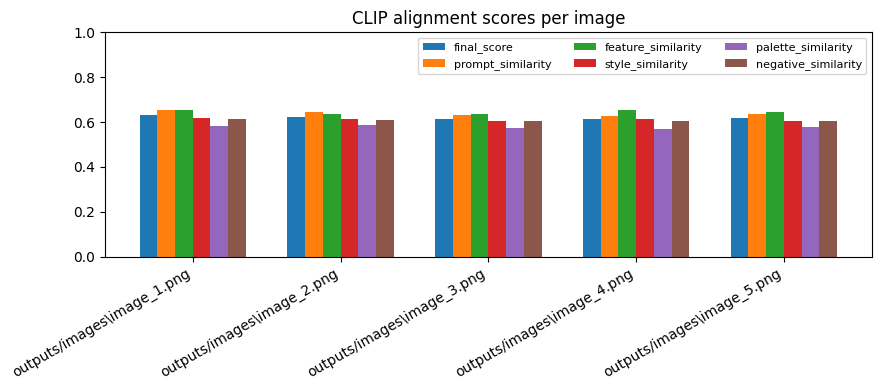

Avg scores: {'final_score': 0.62, 'prompt_similarity': 0.639, 'feature_similarity': 0.645, 'style_similarity': 0.611, 'palette_similarity': 0.578, 'negative_similarity': 0.607}


In [56]:
# plot CLIP eval dynamics and surface tuning hints
import matplotlib.pyplot as plt

if not results:
    raise ValueError("No CLIP results to plot.")

score_keys = [
    "final_score",
    "prompt_similarity",
    "feature_similarity",
    "style_similarity",
    "palette_similarity",
    "negative_similarity",
]

labels = [r.get("image_path", f"img_{i}") for i, r in enumerate(results)]
scores_by_key = {
    k: [r.get("scores", {}).get(k, None) for r in results] for k in score_keys
}

plt.figure(figsize=(9, 4))
x = range(len(labels))
bar_width = 0.12
for i, k in enumerate(score_keys):
    vals = [v if v is not None else 0 for v in scores_by_key[k]]
    plt.bar([p + i * bar_width for p in x], vals, width=bar_width, label=k)
plt.xticks([p + bar_width * (len(score_keys) - 1) / 2 for p in x], labels, rotation=30, ha="right")
plt.ylim(0, 1)
plt.title("CLIP alignment scores per image")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# # per-image detail plots (features/styles/palette)
# for r in results:
#     details = r.get("details", {})
#     for section in ("features", "styles", "palette"):
#         block = details.get(section, {})
#         items = block.get("items", [])
#         vals = block.get("scores", [])
#         if not items or not vals:
#             continue
#         plt.figure(figsize=(7, 3))
#         plt.barh(items, vals)
#         plt.xlim(0, 1)
#         plt.title(f"{section} alignment: {r.get('image_path', 'image')}")
#         plt.tight_layout()
#         plt.show()

# average scores
avg_scores = {k: sum(v for v in scores_by_key[k] if v is not None) / max(1, sum(v is not None for v in scores_by_key[k])) for k in score_keys}
print("Avg scores:", {k: round(v, 3) for k, v in avg_scores.items()})


## 6. Orchestration
...

## 7. Persistence
...

## 8. Iteration / Tuning
...